# bounding box
---
**[실습]**<br>
예1) [LabelImg](https://github.com/heartexlabs/labelImg/releases) 데이터셋 구축<br>
- 이미지 100개를 직접 크롤링하고, 각각의 이미지에 bounding box를 생성하여 모델링<br>

예2) [Roboflow 사이트](https://public.roboflow.com/)에서 제공하는 Raccoon Object Detection Dataset으로 모델링<br>
예3) [Kaggle 데이터셋: 자동차 번호판](https://www.kaggle.com/datasets/andrewmvd/car-plate-detection)으로 모델링<br>
예4) [Kaggle 데이터셋: Cucumber, Eggplant, Mushroom](https://www.kaggle.com/datasets/mbkinaci/image-localization-dataset)으로 모델링<br>

### 필요한 라이브러리 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### 데이터 준비
- Kaggle 데이터셋: 자동차 번호판(Car License Plate Detection)

In [ ]:
# !unzip /content/drive/MyDrive/FLYAI/data/archive.zip -d data

In [ ]:
!cat /content/data/annotations/Cars0.xml


<annotation>
    <folder>images</folder>
    <filename>Cars0.png</filename>
    <size>
        <width>500</width>
        <height>268</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>226</xmin>
            <ymin>125</ymin>
            <xmax>419</xmax>
            <ymax>173</ymax>
        </bndbox>
    </object>
</annotation>

In [ ]:
import glob
import xml.etree.ElementTree as ET

In [ ]:
def xml_to_csv(path):
    xml_list = []

    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = (root.find('filename').text, 
                     int(root.find('size')[0].text), 
                     int(root.find('size')[1].text), 
                     label, 
                     xmin, 
                     ymin, 
                     xmax, 
                     ymax)
            xml_list.append(value)

    column_name = ['filename', 'width', 'height', 
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [ ]:
import os

In [ ]:
csv_path = '/content/data/annotations'
xml_df = xml_to_csv(csv_path)

In [ ]:
xml_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,Cars15.png,400,267,licence,310,146,372,171
1,Cars270.png,400,225,licence,75,173,125,195
2,Cars60.png,400,300,licence,45,98,364,159
3,Cars4.png,590,350,licence,156,82,503,253
4,Cars296.png,400,318,licence,163,158,234,196


In [ ]:
xml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  471 non-null    object
 1   width     471 non-null    int64 
 2   height    471 non-null    int64 
 3   class     471 non-null    object
 4   xmin      471 non-null    int64 
 5   ymin      471 non-null    int64 
 6   xmax      471 non-null    int64 
 7   ymax      471 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 29.6+ KB


In [ ]:
# 이미지 파일 이름: filename
images = xml_df.iloc[:, 0].values
images[:5]

array(['Cars15.png', 'Cars270.png', 'Cars60.png', 'Cars4.png',
       'Cars296.png'], dtype=object)

In [ ]:
# bounding box 좌표: [xmin, ymin, xmax, ymax]
points = xml_df.iloc[:, 4:].values
points[:4]

array([[310, 146, 372, 171],
       [ 75, 173, 125, 195],
       [ 45,  98, 364, 159],
       [156,  82, 503, 253]])

In [ ]:
from tqdm import tqdm
import cv2

In [ ]:
IMAGE_PATH = '/content/data/images'
dataset_images = []
dataset_bbs = []

for file, point in zip(images, points):
    f = os.path.join(IMAGE_PATH, file)
    img = cv2.imread(f)
    h, w, d = img.shape
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    xmin, ymin, xmax, ymax = point[0], point[1], point[2], point[3]
    nxmim, nxmax = int(xmin/w*224), int(xmax/w*224)
    nymin, nymax = int(ymin/h*224), int(ymax/h*224)
    point = [nxmim, nymin, nxmax, nymax]

    dataset_images.append(img)
    dataset_bbs.append(point)

dataset_images = np.array(dataset_images)
dataset_bbs = np.array(dataset_bbs)

In [ ]:
print(dataset_images.shape, dataset_bbs.shape)

(471, 224, 224, 3) (471, 4)


- 시각화

In [ ]:
import PIL

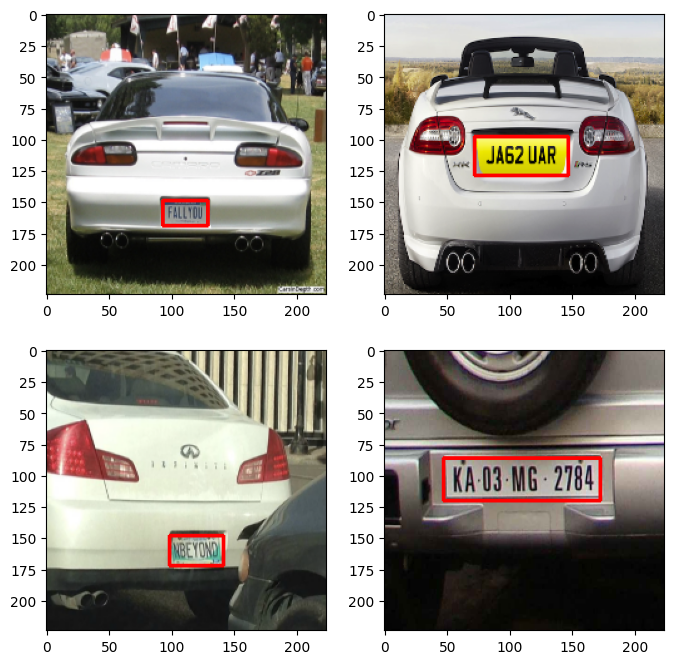

In [ ]:
samples = np.random.randint(dataset_images.shape[0], size=4)

plt.figure(figsize=(8,8))
for i, idx in enumerate(samples):
    points = dataset_bbs[idx].reshape(2, 2)
    img = cv2.rectangle(dataset_images[idx].copy(), 
                        tuple(points[0]), 
                        tuple(points[1]), 
                        color=(255, 0, 0), 
                        thickness=2)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
plt.show()

In [ ]:
np.savez('car_bbs.npz',
         image=dataset_images,
         bbs=dataset_bbs)

In [ ]:
dataset = np.load('car_bbs.npz')

X = dataset['image']
y = dataset['bbs']

X.shape, y.shape

((471, 224, 224, 3), (471, 4))

- 데이터 분리: train data, valid data, test data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.1, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(338, 224, 224, 3) (338, 4)
(38, 224, 224, 3) (38, 4)
(95, 224, 224, 3) (95, 4)


- 정규화

In [ ]:
X_train = X_train.astype('float32')/255.
X_val = X_val.astype('float32')/255.

In [ ]:
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

### 모델링(Modeling)

In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
base = MobileNetV2(input_shape=(224, 224, 3),
                   include_top=False,
                   weights='imagenet')
base.trainable = False

model = keras.Sequential([
    base, 
    layers.Flatten(), 
    layers.Dense(128, activation='relu'), 
    layers.Dense(64, activation='relu'), 
    layers.Dense(4)
])

model.compile(
    optimizer='adam', 
    loss='mse', 
    metrics=['mse']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 10,294,788
Trainable params: 8,036,804
Non-trainable params: 2,257,984
_____________________________________

In [ ]:
ckpt_path = './content/ckpt/cars_bbs.ckpt'

ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path, 
    save_weights_only=True, 
    save_best_only=True, 
    monitor='val_loss', 
    verbose=1
)

In [ ]:
EPOCHS = 30
BATCH_SIZE = 16

log = model.fit(X_train, y_train, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                validation_data=(X_val, y_val), 
                callbacks=[ckpt_cb], 
                verbose=1)

Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 3716.0896 - mse: 3716.0896
Epoch 1: val_loss improved from inf to 1230.71887, saving model to ./content/ckpt/cars_bbs.ckpt
22/22 [==============================] - 9s 151ms/step - loss: 3716.0896 - mse: 3716.0896 - val_loss: 1230.7189 - val_mse: 1230.7189
Epoch 2/30
21/22 [===========================>..] - ETA: 0s - loss: 783.5502 - mse: 783.5502
Epoch 2: val_loss improved from 1230.71887 to 981.99609, saving model to ./content/ckpt/cars_bbs.ckpt
22/22 [==============================] - 1s 58ms/step - loss: 809.9202 - mse: 809.9202 - val_loss: 981.9961 - val_mse: 981.9961
Epoch 3/30
20/22 [==========================>...] - ETA: 0s - loss: 622.0345 - mse: 622.0345
Epoch 3: val_loss did not improve from 981.99609
22/22 [==============================] - 1s 29ms/step - loss: 652.1431 - mse: 652.1431 - val_loss: 1060.1007 - val_mse: 1060.1007
Epoch 4/30
21/22 [===========================>..] - ETA: 0s - loss: 535.6218 - ms

- 학습 과정 시각화

In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.plot(hist['epoch'], hist['mse'], label='Train MSE')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val MSE')

    plt.legend()
    plt.show()

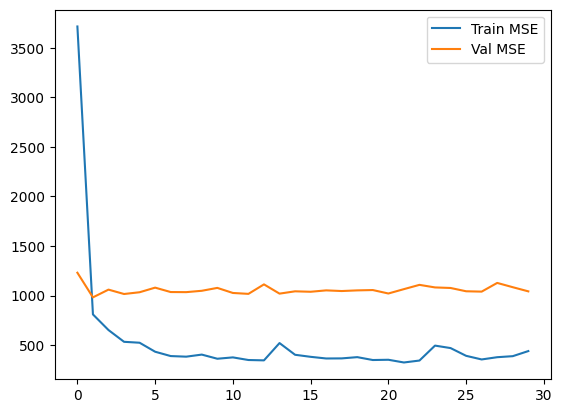

In [ ]:
plot_history(log)

### 평가(Evaluation)

In [ ]:
# best model 불러오기
model.load_weights(ckpt_path)

In [ ]:
model.evaluate(X_val, y_val)

2/2 [==============================] - 1s 17ms/step - loss: 981.9963 - mse: 981.9963


[981.9962768554688, 981.9962768554688]

### 예측(Prediction)

In [ ]:
X_test = X_test.astype('float32')/255.

In [ ]:
y_pred = model.predict(X_test)

3/3 [==============================] - 1s 306ms/step


In [ ]:
y_pred = y_pred.astype('int')

- 시각화

In [ ]:
import cv2

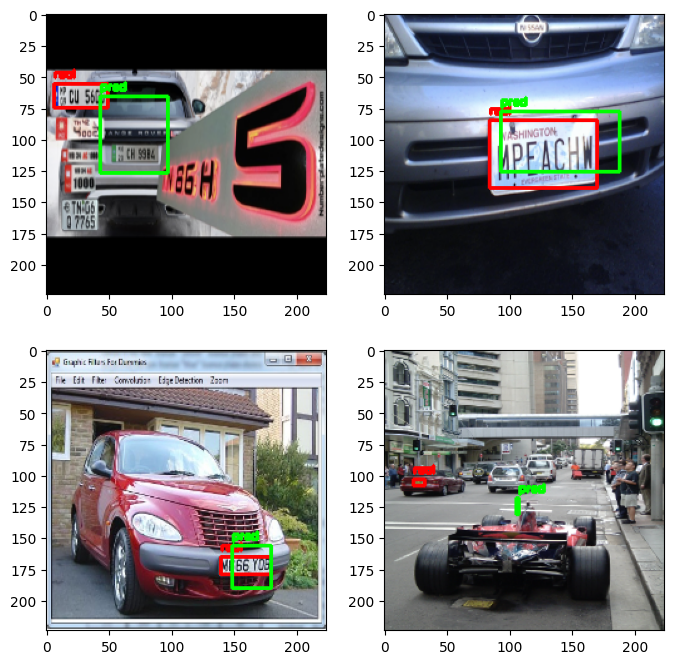

In [ ]:
samples = np.random.randint(X_test.shape[0], size=4)

plt.figure(figsize=(8, 8))
for i, idx in enumerate(samples):
    points = y_test[idx].reshape(2, 2)
    p_points = y_pred[idx].reshape(2, 2)
    img = (X_test[idx].copy()* 255).astype(np.uint8)
    # test bounding box
    cv2.rectangle(img, tuple(points[0]), tuple(points[1]), color=(255, 0, 0), thickness=2)
    cv2.putText(img, 'real', (tuple(points[0])[0], tuple(points[0])[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,0,0), 2)
    # predict bounding box
    cv2.rectangle(img, tuple(p_points[0]), tuple(p_points[1]), color=(0, 255, 0), thickness=2)
    cv2.putText(img, 'pred', (tuple(p_points[0])[0], tuple(p_points[0])[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,255,0), 2)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
plt.show()

In [ ]:
def draw_bbox(img, points, label, color):
    p1 = tuple(points[0])
    p2 = tuple(points[1])
    cv2.rectangle(img, p1, p2, color=color, thickness=1)
    size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, fontScale=0.4, thickness=1)[0]
    
    p2 = p1[0] + size[0] + 1, p1[1] + size[1] - 1
    cv2.rectangle(img, p1, p2, color=color, thickness=-1)
    cv2.putText(img, label, (p1[0], p1[1] + size[1] - 1), 
                cv2.FONT_HERSHEY_PLAIN, fontScale=0.4, color=(255, 255, 255), thickness=1)
    return img

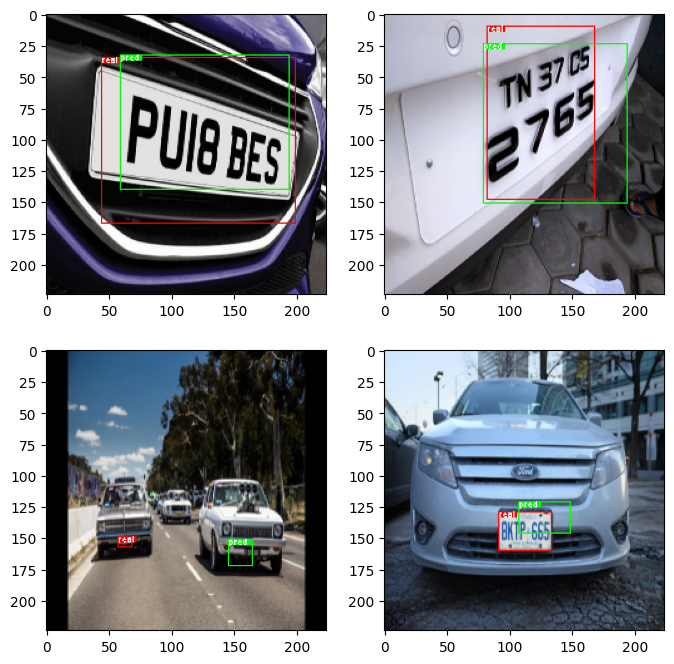

In [ ]:
samples = np.random.randint(X_test.shape[0], size=4)

plt.figure(figsize=(8, 8))
for i, idx in enumerate(samples):
    img = (X_test[idx].copy()* 255).astype(np.uint8)
    test_points = y_test[idx].reshape(2, 2)
    pred_points = y_pred[idx].reshape(2, 2)
    img1 = draw_bbox(img, test_points, 'real', (255, 0, 0))
    img2 = draw_bbox(img1, pred_points, 'pred', (0, 255, 0))
    plt.subplot(2, 2, i+1)
    plt.imshow(img2)
plt.show()